# Implementing ReSTIR-GI

In this tutorial, we will implement the ReSTIR-GI algorithm in Mitsuba3,
published in 2021.
The ReSTIR algorithm and its derivatives have become very popular especially for real
time rendering applications. However, as most implementations are focused on
performance, it can be hard to understand the most common implementations.
The goal of this tutorial is to provide an Implementation for most of the features
provided in the original ReSTIR-GI paper while being easy to understand.

Unfortunately some aspects of my implementation do not work yet, including Jacobean bias correction.

The Original paper can be found under:
Ouyang, Y., Liu, S., Kettunen, M., Pharr, M., & Pantaleoni, J. (2021). [ReSTIR GI.](https://research.nvidia.com/publication/2021-06_restir-gi-path-resampling-real-time-path-tracing)

In [25]:
%pip install mitsuba tqdm matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


First we need to import Mitsuba3 and Dr.Jit
We also have to specify a variant for Mitsuba3.

In [26]:
import mitsuba as mi
import drjit as dr
from tqdm import tqdm
import matplotlib.pyplot as plt

mi.set_variant("cuda_ad_rgb")

Dr.Jit supports creating custom structs, which allow us to zero-initialize members as
well as gathering/scattering them from/into arrays.\
By declaring a `DRJIT_STRUCT` dictionary in the class we can specify the names and types of our
struct members.

The `RestirReservoir` and `RestirSample` both use this feature.\
To avoid having to repeat the type specification we can write a decorator that takes the\
type hints and automatically constructs the `DRJIT_STRUCT` dict.





In [27]:
def drjitstruct(cls):
    from typing import get_type_hints

    drjit_struct = {}

    type_hints = get_type_hints(cls)

    for name, ty in type_hints.items():
        drjit_struct[name] = ty
    cls.DRJIT_STRUCT = drjit_struct
    return cls

The ReSTIR-GI paper has several bias correction steps, one of which is Jacobean
bias correction.
To quote the paper, "If a visible point $x_1^q$ generates a sample point
$x_2^q$ that is reused at another visible point $x_1^r$, then the Jacobean
determinant [...] accounts for the fact that $x_q^r$ would have itself
generated the sample point $x_2^q with a different probability$".
In practice, we need to clamp the angles since they could cause artifacts otherwise.




In [28]:
def J(
    xr1: mi.Vector3f, xq1: mi.Vector3f, xq2: mi.Vector3f, nq2: mi.Vector3f
) -> mi.Float:
    v_rq = xr1 - xq2
    norm_rq = dr.norm(v_rq)
    cos_phi_r = dr.clamp(dr.abs(dr.dot(v_rq, nq2) / norm_rq), 0, 1)

    v_qq = xq1 - xq2
    nrom_qq = dr.norm(v_qq)
    cos_phi_q = dr.clamp(dr.abs(dr.dot(v_qq, nq2) / nrom_qq), 0, 1)

    div = cos_phi_q * dr.sqr(norm_rq)
    jacobian = dr.select(div > 0, cos_phi_r * dr.sqr(nrom_qq) / div, 0)
    return jacobian

The ReSTIR algorithm samples initial samples from a source pdf $p$ and resamples these
according to weights $\omega_i$ where $\omega_i = {\hat p(x_i) \over p(x_i)}$.
Here, $\hat p$ is proportional to the target distribution that could be intractable.


The original paper proposed two different probability density functions for $\hat p$.
In this case we select $\hat p$ to be proportional to the norm of the incoming radiance
$L_i(x_v, w_i)$ at the visible point $x_v$.
One could also consider other functions such as the luminance of the radiance.

In [29]:
def p_hat(f):
    return dr.norm(f)

In Algorithm 4 of the ReSTIR-GI paper a set Q is described which is used for
spatial bias correction at the end.
It saves the count `M`, the position and the normal of the visible points for a
visibility test.
This class implements a `put` method that can be called at every iteration of a loop.
Since the lists in this class are Python lists we have to use a Python loop to
access the variables at their indices as well.
One could also save these variables in a buffer and recall them later, however
since the loop has at most 9 iterations this would be an unnecessary
performance penalty.

In [30]:


class ReuseSet:
    def __init__(self):
        self.M = []
        self.active = []
        self.p = []
        self.n = []

    def put(self, M: mi.UInt, pos: mi.Vector3f, n: mi.Vector3f, active: mi.Bool = True):
        self.M.append(M)
        self.p.append(pos)
        self.n.append(n)
        self.active.append(mi.Bool(active))

    def __len__(self) -> int:
        assert len(self.M) == len(self.p) == len(self.active) == len(self.n)
        return len(self.M)

Now we can implement the `RestirSample` and `RestirReservoir` classes
corresponding to the "SAMPLE" and "RESERVOIR" struct from the paper.

The update and merge functions can be ported directly from the paper and
require just minor adaptions such as using `dr.select` instead of an if-clause.
One point that caused me some headaches is that we have to construct a new
`mi.UInt` to copy the `M` value in the `merge` function as we would otherwise overwrite the old one.
Here we can also utilize the `drjitstruct` decorator specified earlier,
therefore we have to annotate the class members with their correct Mitsuba3
types.





In [31]:
@drjitstruct
class RestirSample:
    x_v: mi.Vector3f
    n_v: mi.Vector3f
    x_s: mi.Vector3f
    n_s: mi.Vector3f

    L_o: mi.Color3f
    p_q: mi.Float
    valid: mi.Bool


@drjitstruct
class RestirReservoir:
    z: RestirSample
    w: mi.Float
    W: mi.Float
    M: mi.UInt

    def update(
        self,
        sampler: mi.Sampler,
        snew: RestirSample,
        wnew: mi.Float,
        active: mi.Bool = True,
    ):
        active = mi.Bool(active)
        if dr.shape(active)[-1] == 1:
            dr.make_opaque(active)

        self.w += dr.select(active, wnew, 0)
        self.M += dr.select(active, 1, 0)
        self.z: RestirSample = dr.select(
            active & (sampler.next_1d() < wnew / self.w), snew, self.z
        )

    def merge(
        self, sampler: mi.Sampler, r: "RestirReservoir", p, active: mi.Bool = True
    ):
        active = mi.Bool(active)
        M0 = mi.UInt(
            self.M
        )  # We have to construct a new UInt so we don't overwrite `self.M`
        self.update(sampler, r.z, p * r.W * r.M, active)
        self.M = dr.select(active, M0 + r.M, M0)

Finally, we can implement our Integrator.
In this tutorial we will use monkey patching to split up the
integrator class over multiple cells.

In the `render` function which we overwrite from `mi.SamplingIntegrator`,
we first seed the sampler with `self.n` and calculate the pixel and sample position similar to the
default integrator.
We also sample in multiple layers if more than 1 sample per pixel was requested.

Since the ReSTIR integrator reuses samples from previous frames
(invocations of `mi.render`) we keep an internal counter `self.n` to seed the sampler and avoid biased results.
This variable is then also used to zero-initialize the reservoirs in the first frame.

For each frame we also keep a copy of the previous sensor around to reproject
temporal samples to new pixels in the temporal resampling step.

We then perform the main Sampling/Resampling algorithm by successively calling:\
    - `sample_initial` for generating initial samples\
    - `temporal_resampling` for resampling from previous frames\
    - `spatial_resampling` for resampling from neighboring pixels\
    - `render_final` for rendering the final image\

To get the rendering time down we also split this part into multiple kernels by
evaluating the changed state variables in between.

In the end we update `self.n` the sensor parameters.
This is used for seeding the sampler.





In [32]:
class RestirIntegrator(mi.SamplingIntegrator):
    dist_threshold = 0.1
    angle_threshold = 25 * dr.pi / 180

    def __init__(self, props: mi.Properties):
        super().__init__(props)
        self.max_depth: int = props.get("max_depth", 8)
        self.rr_depth: int = props.get("rr_depth", 2)
        self.bias_correction = props.get("bias_correction", True)
        self.jacobian = props.get("jacobian", True)
        self.spatial_spatial_reuse = props.get("spatial_spatial_reuse", False)
        self.bsdf_sampling = props.get("bsdf_sampling", True)
        self.max_M_temporal = props.get("max_M_temporal", None)
        self.max_M_spatial = props.get("max_M_spatial", None)
        self.initial_search_radius = props.get("initial_search_radius", 10.0)
        self.minimal_search_radius = props.get("minimal_search_radius", 3.00)
        self.n = 0
        self.film_size: None | mi.Vector2u = None

    def render(
        self,
        scene: mi.Scene,
        sensor: mi.Sensor,
        seed: int = 0,
        spp: int = 1,
        develop: bool = True,
        evaluate: bool = True,
    ):
        """Renders the scene using the ReSTIR-GI algorithm.
        It is better to call `mi.render` instead of calling this funciton manually.

        Args:
            scene: Mitsuba3 Scene to render
            sensor: Sensor position to render from
            seed: per frame seed
            spp: samples per pixel
            develop: Has no effect for this integrator
            evaluate: Has no effect

        Returns:
            The rendered image in the form of a Mitsuba3 TensorXf
        """
        film = sensor.film()

        film_size = film.crop_size()

        if self.film_size is None:
            self.film_size = film_size

        wavefront_size = film_size.x * film_size.y * spp

        sampler = sensor.sampler()
        sampler.set_sample_count(spp)
        sampler.set_samples_per_wavefront(spp)
        sampler.seed(self.n, wavefront_size)

        idx = dr.arange(mi.UInt, wavefront_size)

        pos = mi.Vector2u()
        pos.x = idx // spp % film_size.x
        pos.y = idx // film_size.x // spp
        self.layer = idx % spp
        self.spp = spp

        sample_pos = (mi.Point2f(pos) + sampler.next_2d()) / mi.Point2f(
            film.crop_size()
        )

        if self.n == 0:
            self.temporal_reservoir: RestirReservoir = dr.zeros(
                RestirReservoir, wavefront_size
            )
            self.spatial_reservoir: RestirReservoir = dr.zeros(
                RestirReservoir, wavefront_size
            )
            self.search_radius = dr.full(
                mi.Float, self.initial_search_radius, wavefront_size
            )

            self.prev_sensor: mi.Sensor = mi.load_dict({"type": "perspective"})
            mi.traverse(self.prev_sensor).update(mi.traverse(sensor))

        """
        Main ReSTIR-GI algorithm:
            - Generate Initial Samples
            - Termporal Resampling
            - Spatial Resampling
            - Final Image Generation
        """
        self.sample_initial(scene, sampler, sensor, sample_pos)
        dr.eval(self.sample)  # important to evaluate state to avoid cache misses
        if self.n == 0:
            self.prev_sample = self.sample
        self.temporal_resampling(sampler, mi.Vector2f(pos))
        dr.eval(self.temporal_reservoir)
        self.spatial_resampling(scene, sampler, pos)
        dr.eval(self.spatial_reservoir, self.search_radius)

        res = self.render_final()

        film.prepare(self.aov_names())
        block: mi.ImageBlock = film.create_block()

        aovs = [res.x, res.y, res.z, mi.Float(1)]

        block.put(pos, aovs)

        film.put_block(block)

        img = film.develop()
        dr.eval(img)

        # Update n, prev_sensor and prev_sample
        self.n += 1
        mi.traverse(self.prev_sensor).update(mi.traverse(sensor))
        self.prev_sample = self.sample

        return img

To get the index of a pixel coordinate we define a helper function.
It returns the index of the reservoir in the same layer.




In [33]:
def to_idx(self, pos: mi.Vector2u) -> mi.UInt:
    """Converts a screen space image position to a reservoir index depending on the sample layer.

    Args:
        pos: Position in image space between 0 and width, 0 and height

    Returns:
        Reservoir Index for this pixel and layer.
    """
    pos = dr.clamp(mi.Point2u(pos), mi.Point2u(0), self.film_size)
    assert self.film_size is not None
    return (pos.y * self.film_size.x + pos.x) * self.spp + self.layer


RestirIntegrator.to_idx = to_idx

In the paper, a similarity test is proposed that is used to tell if two reservoirs
should be merged when performing spatial resampling.
This function implements that test with Mitsuba3.





In [34]:
def similar(self, s1: RestirSample, s2: RestirSample) -> mi.Bool:
    """Similarity test from the paper, testing if two points are similar enough.

    Args:
        s1: first RestirSample
        s2: second RestirSample

    Returns:
        `True` if the two samples are similar enough
    """
    dist = dr.norm(s1.x_v - s2.x_v)
    similar = dist < self.dist_threshold
    similar &= dr.dot(s1.n_v, s2.n_v) > dr.cos(self.angle_threshold)

    return similar


RestirIntegrator.similar = similar

The first step in the ReSTIR-GI pipeline is to generate initial samples.

This function is relatively straight forward.
After generating an initial ray we acquire the corresponding visible
point and normal ($x_v, n_v$) by tracing that ray over the scene.
We also save the emittance at this point to use in the `render_final` function.

The next step is to either sample the BSDF pdf or the hemisphere uniformly
to get a new direction.
Both options where described in the paper, however BSDF sampling seems to work better
with Mitsuba3.
We then save the probability density function into the sample and spawn a new ray
to acquire the sample position and normal ($x_s, n_s$).

The incoming radiance $L_i(x_v, \omega_i)$ at point $x_v$ in a direction $\omaga_i$ is
also calculated using the `sample_ray` function.
To this end we ported the sampling function from Mitsuba's path integrator to Python.





In [35]:
def sample_initial(
    self,
    scene: mi.Scene,
    sampler: mi.Sampler,
    sensor: mi.Sensor,
    sample_pos: mi.Point2f,
) -> RestirSample:
    """Samples the initial RestirSample per frame.

    Args:
        scene: Scene to render
        sampler: Sampler used to generate the samples
        sensor: Camera from which to render
        sample_pos: Position of the sample in image space

    Returns:
        The initial sample, which can be used for resampling
    """
    S = RestirSample()
    ray, ray_weight = sensor.sample_ray(0.0, 0.0, sample_pos, mi.Point2f(0.5))

    si: mi.SurfaceInteraction3f = scene.ray_intersect(ray)
    bsdf: mi.BSDF = si.bsdf()

    ds = mi.DirectionSample3f(scene, si, dr.zeros(mi.SurfaceInteraction3f))
    emitter: mi.Emitter = ds.emitter
    self.emittance = emitter.eval(si)

    S.x_v = si.p
    S.n_v = si.n
    S.valid = si.is_valid()
    self.si_v = si

    if self.bsdf_sampling:
        bsdf_sample, bsdf_weight = bsdf.sample(
            mi.BSDFContext(), si, sampler.next_1d(), sampler.next_2d()
        )

        wo = bsdf_sample.wo
        pdf = bsdf_sample.pdf
    else:
        wo = mi.warp.square_to_uniform_hemisphere(sampler.next_2d())
        pdf = mi.warp.square_to_uniform_hemisphere_pdf(wo)

    S.p_q = pdf

    ray = si.spawn_ray(si.to_world(wo))

    S.L_o = self.sample_ray(scene, sampler, ray)

    si: mi.SurfaceInteraction3f = scene.ray_intersect(ray)

    S.x_s = si.p
    S.n_s = si.n

    self.sample = S


RestirIntegrator.sample_initial = sample_initial


def sample_ray(
    self,
    scene: mi.Scene,
    sampler: mi.Sampler,
    ray: mi.Ray3f,
    active: bool = True,
) -> mi.Color3f:
    """Estimate the radiance along a ray using standard path tracing with one path.
    This is a port of the Mitsuba3 PathIntegrator from C++.

    Args:
        scene: Scene tor ender
        sampler: Sampler used for generating random numbers to sample the scene.
        ray: Ray along which the Radiance should be estimated.
        active: Boolean controlling weather the ray tracing and sampling operations should be performed

    Returns:
        The estimated radiance along the path.
    """
    from mitsuba.python.ad.integrators.common import mis_weight

    # --------------------- Configure loop state ----------------------

    ray = mi.Ray3f(ray)
    active = mi.Bool(active)
    throughput = mi.Spectrum(1.0)
    result = mi.Spectrum(0.0)
    eta = mi.Float(1.0)
    depth = mi.UInt32(0)

    valid_ray = mi.Bool(scene.environment() is not None)

    # Variables caching information from the previous bounce
    prev_si: mi.SurfaceInteraction3f = dr.zeros(mi.SurfaceInteraction3f)
    prev_bsdf_pdf = mi.Float(1.0)
    prev_bsdf_delta = mi.Bool(True)
    bsdf_ctx = mi.BSDFContext()

    loop = mi.Loop(
        "Path Tracer",
        state=lambda: (
            sampler,
            ray,
            throughput,
            result,
            eta,
            depth,
            valid_ray,
            prev_si,
            prev_bsdf_pdf,
            prev_bsdf_delta,
            active,
        ),
    )

    loop.set_max_iterations(self.max_depth)

    while loop(active):
        # TODO: not necesarry in first interaction
        si = scene.ray_intersect(ray)

        # ---------------------- Direct emission ----------------------

        ds = mi.DirectionSample3f(scene, si, prev_si)
        em_pdf = mi.Float(0.0)

        em_pdf = scene.pdf_emitter_direction(prev_si, ds, ~prev_bsdf_delta)

        mis_bsdf = mis_weight(prev_bsdf_pdf, em_pdf)

        result = dr.fma(
            throughput,
            ds.emitter.eval(si, prev_bsdf_pdf > 0.0) * mis_bsdf,
            result,
        )

        active_next = ((depth + 1) < self.max_depth) & si.is_valid()

        bsdf: mi.BSDF = si.bsdf(ray)

        # ---------------------- Emitter sampling ----------------------

        active_em = active_next & mi.has_flag(bsdf.flags(), mi.BSDFFlags.Smooth)

        ds, em_weight = scene.sample_emitter_direction(
            si, sampler.next_2d(), True, active_em
        )

        wo = si.to_local(ds.d)

        # ------ Evaluate BSDF * cos(theta) and sample direction -------

        sample1 = sampler.next_1d()
        sample2 = sampler.next_2d()

        bsdf_val, bsdf_pdf, bsdf_sample, bsdf_weight = bsdf.eval_pdf_sample(
            bsdf_ctx, si, wo, sample1, sample2
        )

        # --------------- Emitter sampling contribution ----------------

        bsdf_val = si.to_world_mueller(bsdf_val, -wo, si.wi)

        mi_em = dr.select(ds.delta, 1.0, mis_weight(ds.pdf, bsdf_pdf))

        result[active_em] = dr.fma(throughput, bsdf_val * em_weight * mi_em, result)

        # ---------------------- BSDF sampling ----------------------

        bsdf_weight = si.to_world_mueller(bsdf_weight, -bsdf_sample.wo, si.wi)

        ray = si.spawn_ray(si.to_world(bsdf_sample.wo))

        # ------ Update loop variables based on current interaction ------

        throughput *= bsdf_weight
        eta *= bsdf_sample.eta
        valid_ray |= (
            active
            & si.is_valid()
            & ~mi.has_flag(bsdf_sample.sampled_type, mi.BSDFFlags.Null)
        )

        prev_si = si
        prev_bsdf_pdf = bsdf_sample.pdf
        prev_bsdf_delta = mi.has_flag(bsdf_sample.sampled_type, mi.BSDFFlags.Delta)

        # -------------------- Stopping criterion ---------------------

        depth[si.is_valid()] += 1

        throughput_max = dr.max(throughput)

        rr_prop = dr.minimum(throughput_max * dr.sqr(eta), 0.95)
        rr_active = depth >= self.rr_depth
        rr_continue = sampler.next_1d() < rr_prop

        throughput[rr_active] *= dr.rcp(rr_prop)

        active = (
            active_next & (~rr_active | rr_continue) & (dr.neq(throughput_max, 0.0))
        )

    return dr.select(valid_ray, result, 0.0)


RestirIntegrator.sample_ray = sample_ray

The next step is to perform temporal resampling.

Here we first test if the sample in the temporal reservoir at the current pixel
is valid i.e. if the sample is similar enough to the sample that previously corresponding
to this pixel.

To reproject the position of the current sample from the previous sensor position we
somewhat abuse the `sample_direction` function of that sensor by constructing a
`SurfaceInteraction3f` and populating it with the position of the current sample.
Depending on the result of that test we either construct a new reservoir or
reuse the old one.

Clamping the parameter `M` of the reservoir to prevent
stale samples is mentioned.
This does not work if we simply where to limit that parameter and not merge the
reservoir.
Therefore, we construct a new reservoir `Rnew` and merge the old one into it.
We also update this new reservoir with the new sample generated in this frame and
then clamp `M` of the new reservoir and overwrite the old one.





In [36]:
def temporal_resampling(
    self,
    sampler: mi.Sampler,
    pos: mi.Vector2f,
):
    """Implements temporal resampling from the paper.

    Args:
        sampler: Sampler used to generate the random numbers, which are required for merging/updating reservoirs
        pos: Image space position of the pixel
    """
    S = self.sample

    si: mi.SurfaceInteraction3f = dr.zeros(mi.SurfaceInteraction3f)
    si.p = S.x_v
    ds, _ = self.prev_sensor.sample_direction(
        si, mi.Point2f(0.0)
    )  # type: tuple[mi.DirectionSample3f, mi.Color3f]
    ds: mi.DirectionSample3f = ds

    valid = ds.pdf > 0

    Sprev: RestirSample = dr.gather(
        RestirSample, self.prev_sample, self.to_idx(mi.Point2u(ds.uv)), valid
    )

    valid &= self.similar(S, Sprev)

    R = dr.select(valid, self.temporal_reservoir, dr.zeros(RestirReservoir))

    """
    Create a new reservoir to update with the new sample and merge the old temporal reservoir into.
    This is necesarry to limit the samples in the old temporal reservoir (M-clamping).
    """
    Rnew: RestirReservoir = dr.zeros(RestirReservoir)

    phat = p_hat(S.L_o)
    w = dr.select(S.p_q > 0, phat / S.p_q, 0.0)  # Weight for new sample
    Rnew.update(sampler, S, w)  # Add new sample to Rnew

    # add min(R.M, CLAMP) samples from R
    Rnew.merge(sampler, R, p_hat(R.z.L_o))

    phat = p_hat(Rnew.z.L_o)
    Rnew.W = dr.select(
        phat * Rnew.M > 0, Rnew.w / (Rnew.M * phat), 0
    )  # Update Contribution Weight W in Rnew

    if self.max_M_temporal is not None:
        Rnew.M = dr.minimum(Rnew.M, self.max_M_temporal)

    self.temporal_reservoir = Rnew


RestirIntegrator.temporal_resampling = temporal_resampling

Similarly to temporal resampling, spatial resampling reuses samples from nearby pixels.

The first step is again to construct a new reservoir `Rnew` to allow for clamping `M`.
Depending on whether we want to enable reuse from previous spatial reservoirs,
the old spatial reservoir is merged into the new one.
We then calculate the maximum number of iterations according to the criterion outlined
in the paper.
To determine if the search radius should be decreased (if no samples could be reused) we also initialize the
boolean `any_reused`.

The main spatial resampling loop cannot be a Dr.Jit loop because we have to calculate
the spatial bias correction factor at the end using values added to the set `Q`.
Since a Dr.Jit loop is only run once in Python to record the computations, it
is not easily possible to access the elements in the list of `Q`.
Note, that for Dr.Jit the list looks like any other set of variables which
correspond to CUDA registers on the GPU.





In [37]:
def spatial_resampling(
    self,
    scene: mi.Scene,
    sampler: mi.Sampler,
    pos: mi.Vector2u,
):
    """Implements Spatial resampling from the paper.

    Args:
        scene: Scene to render
        sampler: Generates random numbers for merging reservoirs
        pos: Image space position of the pixel
    """
    Rs = self.spatial_reservoir

    Rnew: RestirReservoir = dr.zeros(RestirReservoir)
    Q = ReuseSet()

    q: RestirSample = self.sample

    Z = mi.UInt(0)

    if self.spatial_spatial_reuse:
        Rnew.merge(sampler, Rs, p_hat(Rs.z.L_o))
        Z += Rs.M

    max_iter = dr.select(Rs.M < self.max_M_spatial / 2, 9, 3)

    any_reused = dr.full(mi.Bool, False, len(pos.x))

    for s in range(9):
        active = s < max_iter

        offset = mi.warp.square_to_uniform_disk(sampler.next_2d()) * self.search_radius
        p = dr.clamp(pos + mi.Vector2i(offset), mi.Point2u(0), self.film_size)

        qn: RestirSample = dr.gather(RestirSample, self.sample, self.to_idx(p))

        active &= self.similar(qn, q)

        Rn: RestirReservoir = dr.gather(
            RestirReservoir, self.temporal_reservoir, self.to_idx(p), active
        )  # l.9

        si: mi.SurfaceInteraction3f = dr.zeros(mi.SurfaceInteraction3f)
        si.p = q.x_v
        si.n = q.n_v
        shadowed = scene.ray_test(si.spawn_ray_to(Rn.z.x_s), active)

        phat = dr.select(
            ~active | shadowed,
            0,
            p_hat(Rn.z.L_o)
            * (
                dr.clamp(J(q.x_v, Rn.z.x_v, Rn.z.x_s, Rn.z.n_s), 0, 1000)
                if self.jacobian
                else 1.0
            ),
        )  # l.11 - 13

        Rnew.merge(sampler, Rn, phat, active)

        Q.put(Rn.M, Rn.z.x_v, Rn.z.n_v, active)

        any_reused |= active

    phat = p_hat(Rnew.z.L_o)
    if self.bias_correction:
        for i in range(len(Q)):
            active = Q.active[i]

            si: mi.SurfaceInteraction3f = dr.zeros(mi.SurfaceInteraction3f)
            si.p = Rnew.z.x_s
            si.n = Rnew.z.n_s
            ray = si.spawn_ray_to(Q.p[i])

            # active &= dr.dot(ray.d, Q.n[i]) < 0
            active &= ~scene.ray_test(ray, active)

            Z += dr.select(active, Q.M[i], 0)

        Rnew.W = dr.select(Z * phat > 0, Rnew.w / (Z * phat), 0.0)
    else:
        Rnew.W = dr.select(phat * Rnew.M > 0, Rnew.w / (Rnew.M * phat), 0)

    # Decrease search radius:
    self.search_radius = dr.maximum(
        dr.select(any_reused, self.search_radius, self.search_radius / 2),
        self.minimal_search_radius,
    )

    if self.max_M_spatial is not None:
        Rnew.M = dr.minimum(Rnew.M, self.max_M_spatial)

    self.spatial_reservoir = Rnew


RestirIntegrator.spatial_resampling = spatial_resampling

Finally, we can implement the function, that calculates the image for this frame.
According to the ReSTIR algorithm the target integral is equal to
$\hat L = {f(x_s) \over \hat p(x_s)} {1 \over M} \sum^M_{i = 1}{\hat p(x_i) \over p(x_i)}$
In this case $\text{R.W} = {1 \over \hat p(x_s)} {1 \over M} \sum^M_{i = 1}{\hat p(x_i) \over p(x_i)}$.
Evaluating the BSDF and adding the emittance we can compute the outgoing radiance
towards the sensor.

In [38]:


def render_final(self) -> mi.Color3f:
    """Render the final image after spatio-temporal resampling.

    Args:

    Returns:
        The estimated color for the pixel
    """
    assert self.film_size is not None
    R = self.spatial_reservoir
    S = R.z

    si = self.si_v
    bsdf: mi.BSDF = self.si_v.bsdf()
    β = bsdf.eval(mi.BSDFContext(), si, si.to_local(dr.normalize(S.x_s - si.p)))

    result = β * S.L_o * R.W + self.emittance

    return result


RestirIntegrator.render_final = render_final

Now we can register the `RestirIntegrator` with Mitsuba3 and render some images.
We use the default Cornell Box scene and modify its resolution as well as the reconstruction filter.
Note, that we do not have to set the seed as we use an internal variable that
is incremented every time the `render` function gets called.
One could also conceive more elaborate setups such as a moving camera or a more
complex scene to test the Integrator.
We render the scene for 200 frames with 1spp for every frame.
The images are written to a `out/` directory and in the notebook only the last
frame is shown.

Rendering Reference Image:
ReSTIRGI:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:18<00:00, 10.97it/s]


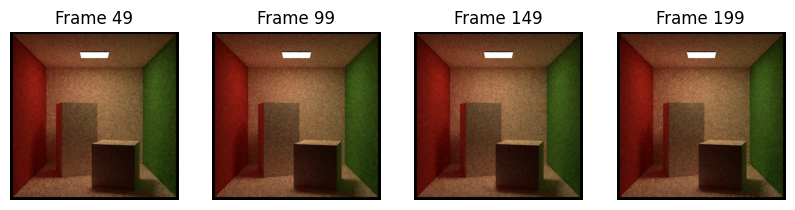

In [39]:

mi.register_integrator("restirgi", lambda props: RestirIntegrator(props))

with dr.suspend_grad():
    scene = mi.cornell_box()
    scene["sensor"]["film"]["width"] = 1024
    scene["sensor"]["film"]["height"] = 1024
    scene["sensor"]["film"]["rfilter"] = mi.load_dict({"type": "box"})
    scene: mi.Scene = mi.load_dict(scene)

    print("Rendering Reference Image:")
    ref = mi.render(scene, spp=256)
    mi.util.write_bitmap("out/ref.jpg", ref)

    integrator: RestirIntegrator = mi.load_dict(
        {
            "type": "restirgi",
            "jacobian": False,
            "bias_correction": True,
            "bsdf_sampling": True,
            "max_M_spatial": 500,
            "max_M_temporal": 30,
            "initial_search_radius": 10,
        }
    )

    print("ReSTIRGI:")
    imgs = []
    for i in tqdm(range(200)):
        img = mi.render(scene, integrator=integrator, spp=1)

        mi.util.write_bitmap(f"out/{i}.jpg", img)

        if (i + 1) % 50 == 0:
            imgs.append((i, img))

    fig, ax = plt.subplots(1, len(imgs), figsize=(10, 40))
    for i in range(len(imgs)):
        ax[i].axis("off")
        ax[i].imshow(mi.util.convert_to_bitmap(imgs[i][1]))
        ax[i].set_title(f"Frame {imgs[i][0]}")